<a href="https://colab.research.google.com/github/kobrue02/evaluating-llm-generated-nlu-data/blob/main/bin/notebooks/evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/kobrue02/evaluating-llm-generated-nlu-data/
%cd evaluating-llm-generated-nlu-data

Cloning into 'evaluating-llm-generated-nlu-data'...
remote: Enumerating objects: 712, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 712 (delta 79), reused 63 (delta 34), pack-reused 591 (from 1)
Receiving objects: 100% (712/712), 1.67 MiB | 21.62 MiB/s, done.
Resolving deltas: 100% (461/461), done.
/content/evaluating-llm-generated-nlu-data


In [5]:
import json
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

In [6]:
from bin.utils.read_datasets import read_sipgate_dataset
from bin.utils.clean_sipgate_dataset import clean_sipgate_dataset
from bin.framework.framework import Framework

In [7]:
import logging
logging.basicConfig(level=logging.INFO)

In [8]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [9]:
dataset_names = [
    "persona_based_prompt_s1_data",
    "few_shot_simple_data",
    "chain_of_thought_simple_data",
    "few_shot_simple_data",
    "one_shot_simple_data",
]

In [10]:
def results_to_dataframe(results: list[dict]):
    # Initialize an empty DataFrame
    columns = ["intent"] + list(list(results[0].values())[0]["results"].keys())
    df = pd.DataFrame(columns=columns)
    df.set_index("intent", inplace=True)

    # Process each intent dictionary
    for intent_dict in results:
        for intent_name, data in intent_dict.items():
            results = data["results"]
            df.loc[intent_name] = results

    df["intent"] = df.index
    df.reset_index(drop=True, inplace=True)

    return df

In [11]:
def dfs_to_stripplots(dfs: list[pd.DataFrame]):
    # make a dashboard of plots
    # where each plot is the distribution of a metric
    # across all intents
    n_metrics = len([col for col in dfs[0].columns if not dfs[0][col].isnull().all()]) - 1
    n_cols = 2
    n_rows = -(-n_metrics // n_cols)  # Ceiling division

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axs = axs.flatten()
    colors = sns.color_palette("husl", n_rows)
    for i, metric in enumerate(dfs[0].columns[1:]):
        if metric == "intent":
            continue

        ax = axs[i]
        ax.set_title(metric)
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")

        for i, df in enumerate(dfs):
          x, y = df[metric].index, df[metric].values
          sns.stripplot(
            data=df,
            x=metric,
            ax=ax,
            color=colors[i],
            alpha=0.5,
            linewidth=0,
          )

    plt.tight_layout()
    plt.show()

In [12]:
def transform_dfs_to_metric_dfs(dfs: list[pd.DataFrame]):
    metric_dfs = []
    metrics = [
        col for col in dfs[0].columns
        if not dfs[0][col].isnull().all()
        and col != "intent"
        ]
    for metric in metrics:
      columns = ["intent"] + [dataset_names[i] for i in range(len(dfs))]
      df = pd.DataFrame(columns=columns)
      df.set_index("intent", inplace=True)
      for i, df_ in enumerate(dfs):
        df[dataset_names[i]] = df_[metric]
      df["intent"] = df.index
      df.reset_index(drop=True, inplace=True)
      metric_dfs.append(df)
    return metric_dfs


In [13]:
def load_df(dataset_name: str):
    gen_df = pd.read_csv(f"data/{dataset_name}.csv", encoding="utf-8")
    gen_df.rename(columns={"query": "text"}, inplace=True)
    gen_df = gen_df[gen_df["text"].apply(lambda x: isinstance(x, str))]
    return gen_df

In [15]:
raw_dfs = [load_df(dataset_name) for dataset_name in dataset_names]
ref_df = clean_sipgate_dataset(read_sipgate_dataset())

In [16]:
framework = Framework()
evaluated_sets = []
for gen_df in raw_dfs:
  results = framework.apply_framework_to_datasets(gen_df, ref_df)
  df = results_to_dataframe(results)
  evaluated_sets.append(df)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

100%|██████████| 92/92 [01:03<00:00,  1.46it/s]


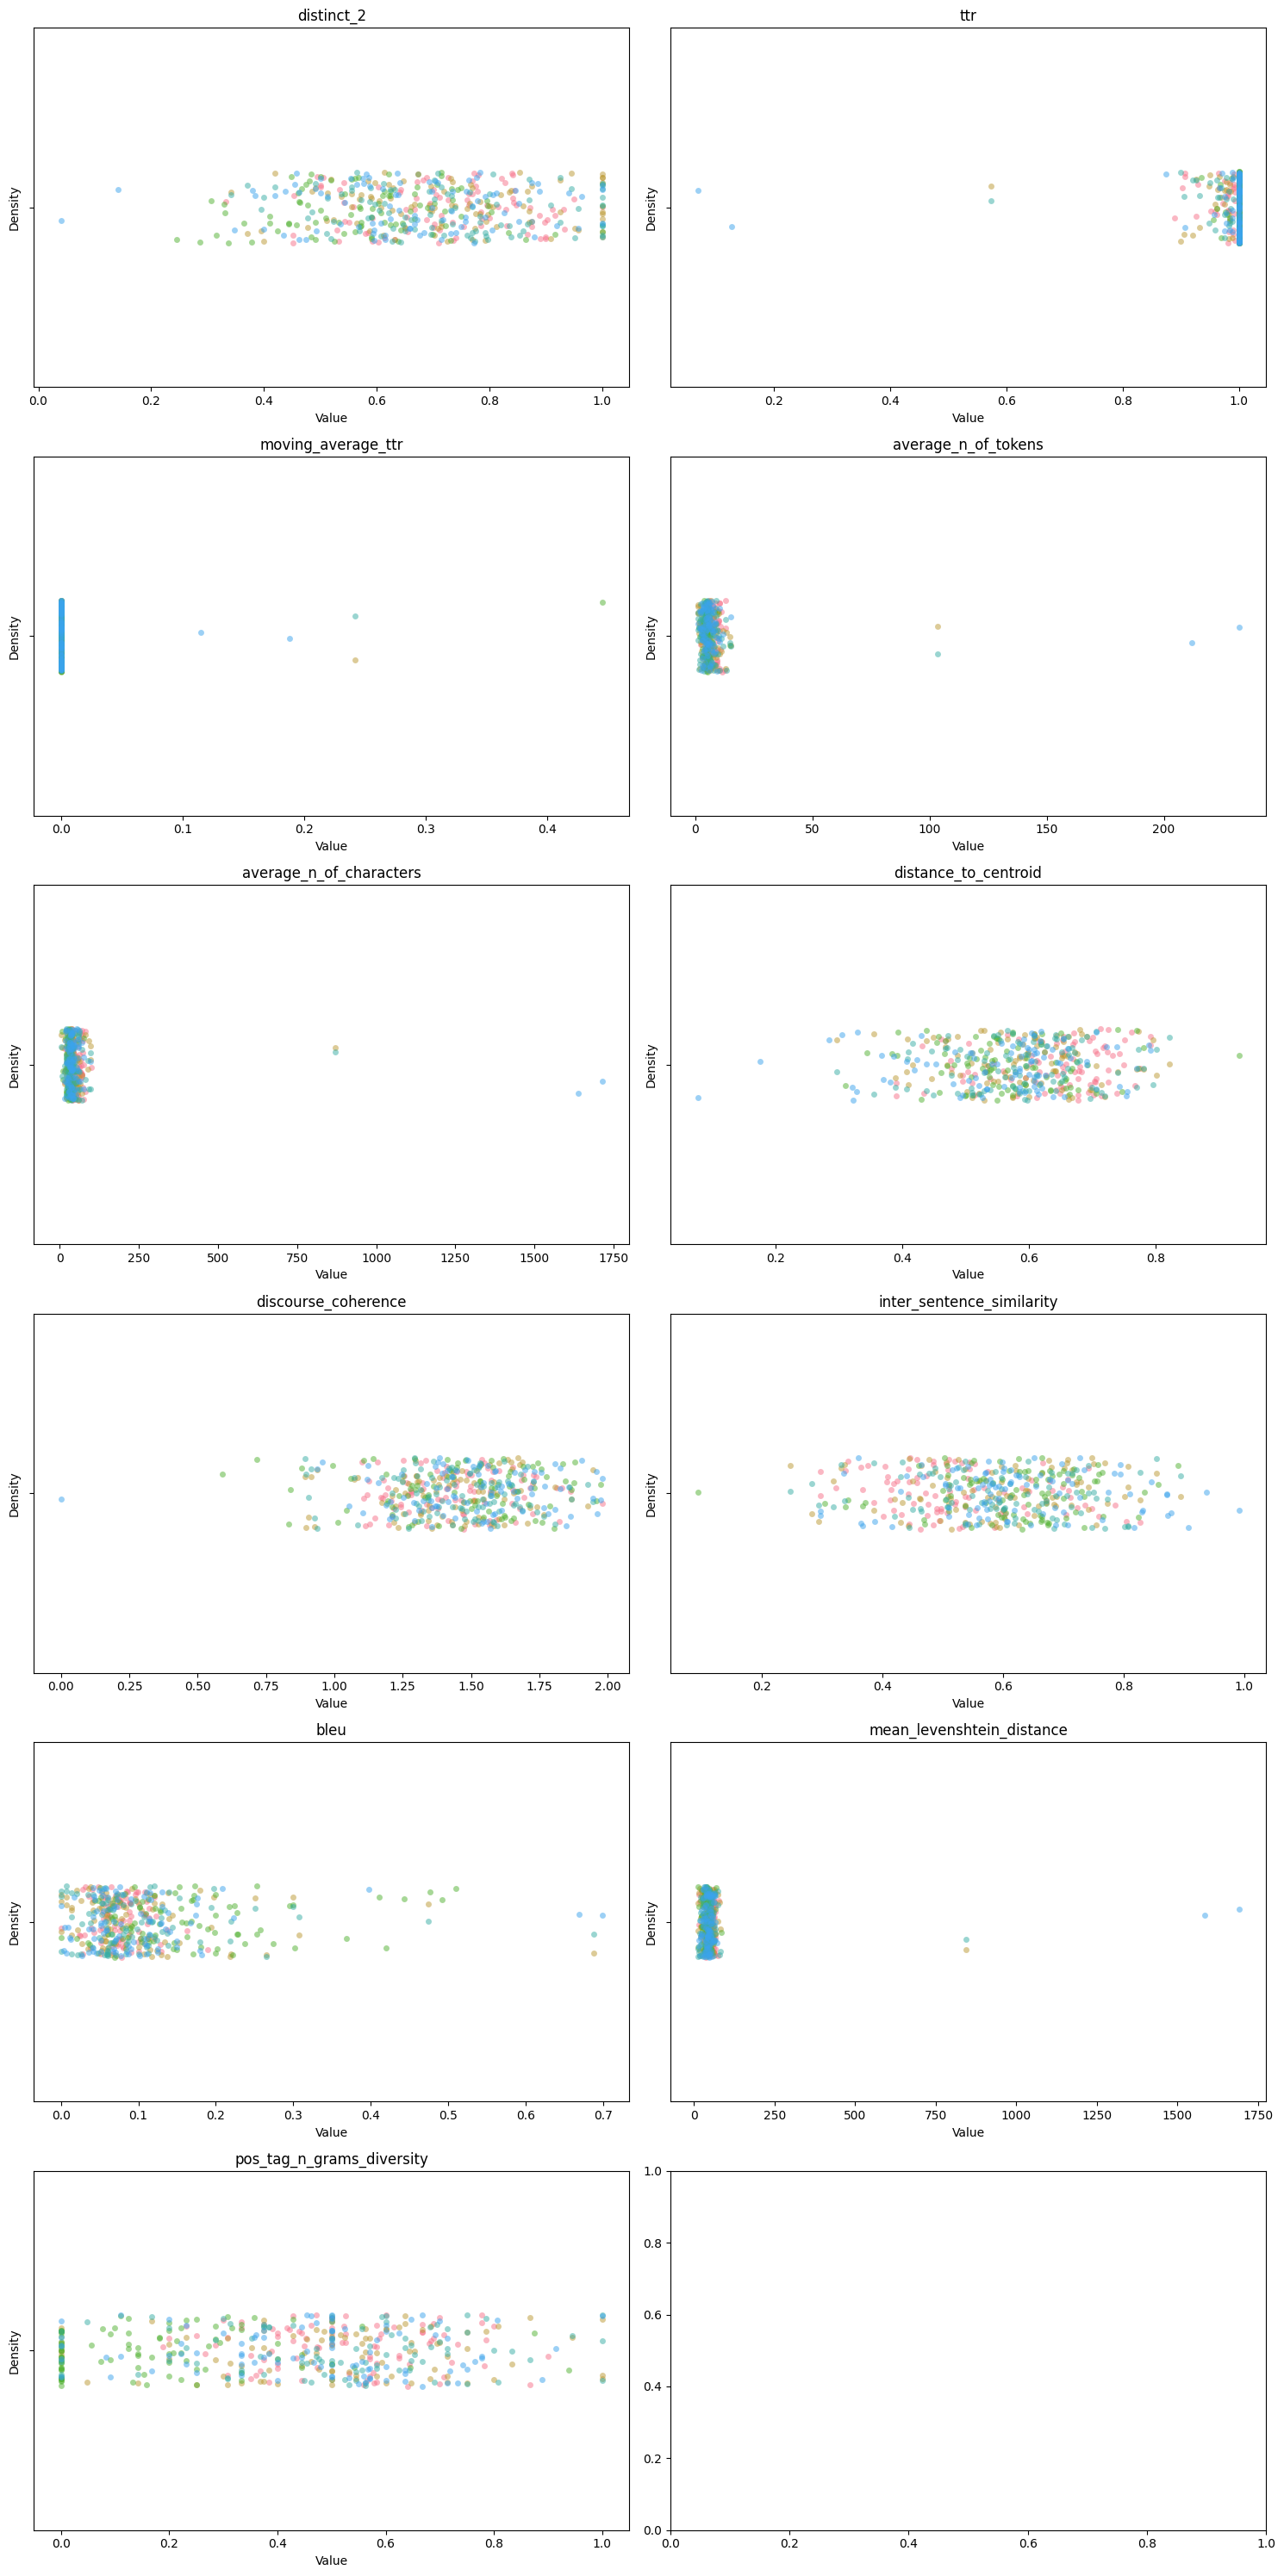

In [17]:
dfs_to_stripplots(evaluated_sets)

In [18]:
metric_dfs = transform_dfs_to_metric_dfs(evaluated_sets)
metric_names = list(framework.metrics)

In [26]:
def catplot_metric_dfs(metric_dfs: list[pd.DataFrame]):
    n_metrics = len(metric_dfs)
    n_cols = 2
    n_rows = -(-n_metrics // n_cols)  # Ceiling division
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

    # Flatten axs in case of single row
    axs = axs.flatten() if n_metrics > 1 else [axs]

    for i, metric_df in enumerate(metric_dfs):
        metric_df_melted = metric_df.melt(id_vars=['intent'], var_name='Metric', value_name='Value')
        # remove extreme outliers
        q1 = metric_df_melted['Value'].quantile(0.25)
        q3 = metric_df_melted['Value'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        metric_df_melted = metric_df_melted[(metric_df_melted['Value'] >= lower_bound) & (metric_df_melted['Value'] <= upper_bound)]
        sns.boxplot(
            data=metric_df_melted,
            x='Metric',
            y='Value',
            ax=axs[i],
            palette="pastel",
            hue="Metric",
            legend=False
            )
        # rotate x labels
        axs[i].get_xaxis().set_tick_params(rotation=90)
        axs[i].set_title(metric_names[i].value)
    plt.tight_layout()
    plt.show()

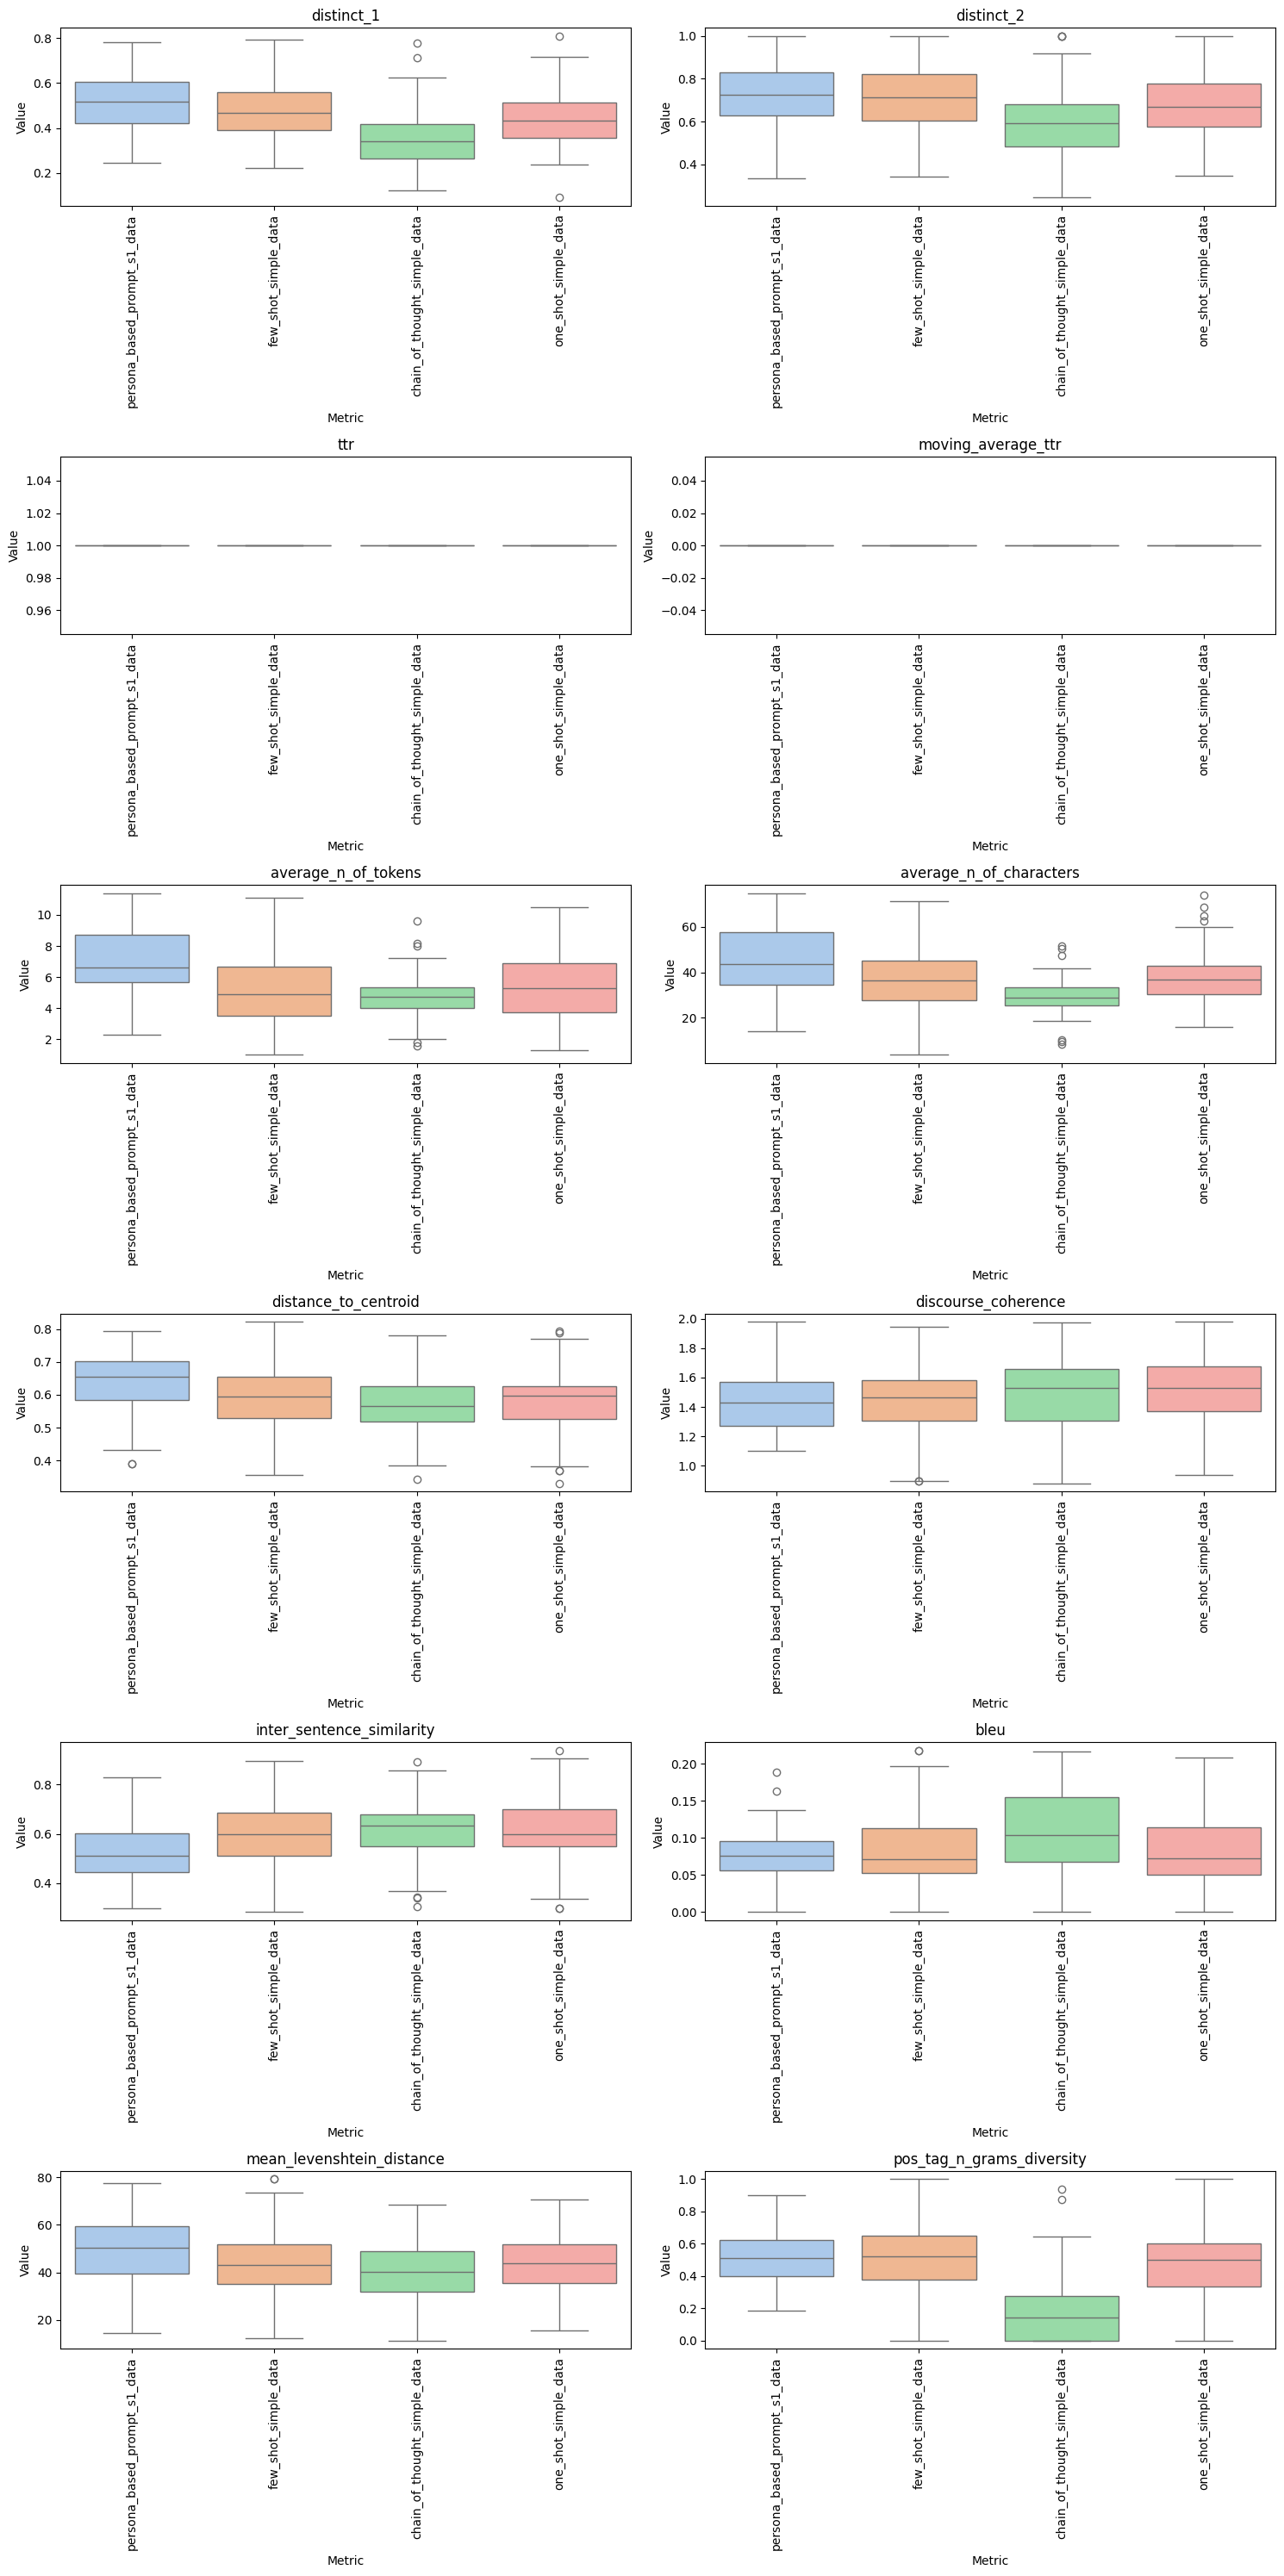

In [27]:
catplot_metric_dfs(metric_dfs)